# Click through rate case: T-test vs $\chi^2$-test

We will purposely apply a t-test in CTR data to see how it works in this situation.

After running an experiment in which we have presented two versions of an advertisement, we are interested in determining if one advertisement is better (in a statistically significanct sense) than another.

First, let us import some libraries and load the data set:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2, chi2_contingency


In [2]:
df = pd.read_csv("data/advertisement_clicks.csv")

In [3]:
df.head()

,advertisement_id,action
0,B,1
1,B,1
2,A,0
3,B,0
4,A,1


In [4]:
df.shape

(2000, 2)

The first column represents the version of advertisement we placed on-line: versions A or B. The second column represents the action users did: 1 represents click and 0 no-click for each one of the impressions.

First we should check whether the impressions we collected coming from versions A and B are equal in number.

In [5]:
df.advertisement_id.value_counts()

A    1000
B    1000
Name: advertisement_id, dtype: int64

So, N = 1000. We know that the **CRT action is a random variable with Bernoulli distribution** and parameter p = 0.5. So in this case our variance is 0.5 as well. In this setting we don't fulfill the conditions for applying a t-test which require normal distributions. Still, we first will perform this test to see what conclusion we derive from it. 

As we want to maximize CRT the version which performs better this action will "win". So, we can write our hypothesis system as follow:

$$ H_0: CRT_A = CRT_B $$

$$ H_1: CRT_A\neq CRT_B$$

Remember that $CRT_A = \frac{1}{1000} \sum (X_i)$ where $ X_i\cong Bernoulli(0.5)$.

First, let us isolate the data coming from groups A and B and find the means of the samples:

In [6]:
a = df[df['advertisement_id'] == 'A']["action"]
b = df[df['advertisement_id'] == 'B']["action"]

print("A_mean = {}".format(a.mean()))
print("B_mean = {}".format(b.mean()))

A_mean = 0.304
B_mean = 0.372


# Naive t-test

We will perform first a two side t-test, assuming that the populations have the same variance: 

In [7]:
t, p = stats.ttest_ind(a, b)
print("t-statistic: {}".format(t))
print("p-value: {}".format(p))



t-statistic: -3.2211732138019786
p-value: 0.0012971905467125246


According with this values, at a level of significance $\alpha = 0.05$, we should reject the null hypothesis because p < 0.05 which means that there is a high probability that the version A or version B have different Click-through rates.

# Welch's t-test

Here we are under the hypothesis of different variances between the two groups.

In [8]:
t, p = stats.ttest_ind(a, b, equal_var=False)

print("Welch's t-test:")

print("t-statistic: {}".format(t))
print("p-value: {}".format(p))

Welch's t-test:
t-statistic: -3.2211732138019786
p-value: 0.0012972410374001632


With this test, we have the same results as above. So, in this case we would reject the null hypothesis as well.

**Note**: Scipy always run a two-tailed test according to the documentation. If we want to run a one-tailed test we must divide the p-value obtained by 2. 

# $\chi^2$ Test Statistic

This is suitable for the kind of distribution we have here, that is for random variables i.i.d. with  Bernoulli distribution. Obviously this statistic follows a $\chi^2$ distribution. The values in this distribution are always positive, and like t-distribution we have just one parameter which is the number of degrees of freedom.

$$\chi^2 = \sum_i \dfrac{(observed_i-expected_i)^2}{expected_i} = \dfrac{det(T)^2(a+b+c+d)}{(a+b)(c+d)(a+c)(b+d)}$$

Where T is the contingency table showing the clicks and no clicks of the groups A and B:

* a : \# clicks in A
* b : \# no_clicks in A
* c:  \# clicks in B
* d:  \# no_clicks in B

In general this test works for any categorical variables where we count things. First we will create a contingency table from our data set:

In [9]:
cont = df.groupby("advertisement_id").sum().reset_index().rename(columns = {"action": "click"})
cont["No_click"] = 1000-cont["click"]
cont.set_index("advertisement_id", inplace = True)
cont

,click,No_click
advertisement_id,,
A,304,696
B,372,628


Let us create a function computing the $\chi^2$-statistic when we have two groups:

In [10]:
def chi_new(table):
    det = np.linalg.det(table)
    traces = np.sum(table)
    den = T[0].sum() * T[1].sum() * T[:,0].sum()*T[:,1].sum()
    return det**2 * traces/den

Also, we can calculate the p-value which is again the probability of obtaining a real change, i.e. the probability that our observations had an extreme $\chi^2$-value, i.e. far away from expected so $\chi^2$ is large and therefore, $p = 1-CDF(\chi^2)$ is a small number.

In [11]:
a = np.array(cont.loc["A"])
b = np.array(cont.loc["B"])
#contingency matrix
T= np.array([a,b])

In [12]:
print("chi^2 = {}".format(chi_new(T)))
print("p-value = {}".format(1-chi2.cdf(x=chi_new(T), df=1)))


chi^2 = 10.33268381629988
p-value = 0.0013069502732125926


From this, at significance level $\alpha = 0.05$, since $p<\alpha$, we have that there is a high probability that the two ads have significantly different CTR.

We can also run the same analysis using in-built functions in scipy:

In [13]:
# In-built function in scipy
chi, p, dof, expected = stats.chi2_contingency(cont, correction = False)

print("Chi^2 statistic = {}".format(chi))
print("p-value = {}".format(p))
print("Degrees of freedom = {}".format(dof))
print("Expected values = {}".format(expected[0]))

Chi^2 statistic = 10.332683816299898
p-value = 0.0013069502732125406
Degrees of freedom = 1
Expected values = [338. 662.]


In [14]:
stats.chi2_contingency(cont, correction = False)[1]

0.0013069502732125406

**Main conclusions:**  

* We reject the null hypothesis after running both tests but the t-test is not suitable in this setting because our random variables (clicks or not clicks) are not normally distributed but Bernoulli distributed. We also could apply the Fisher test in this situation.

* The $\chi^2$-test is also suitable when we are interested in product quantities purchased.

* When measuring revenue as conversion, using t-test is a good option because we can assume a normal distribution of our random variable (revenue).

# Simulations of data in this setting

We can emulate different data for our experiment. Below we construct functions to create data, and plots using 

In [15]:
class DataGenerator:
    def __init__(self, pA, pB):
        self.p1 = pA
        self.p2 = pB

    def next(self):
        """
        Returns the result of whether a person clicks or not in the ad A or B
        """
        clickA = 1 if (np.random.random() < self.p1) else 0
        clickB = 1 if (np.random.random() < self.p2) else 0
        return clickA, clickB

def run_experiment(pA, pB, N):
    """
    pA is the probability of click for group A, and pB the probability of click for group B.
    N is the number of iterations.
    """
    data = DataGenerator(pA, pB)
    p_values = np.empty(N)
    T = np.zeros((2, 2)).astype(np.float32)
    for i in range(N):
        cA, cB = data.next()
        T[0,cA] += 1
        T[1,cB] += 1
    # ignore the first 10 values
        if i < 10:
            p_values[i] = None
        else:
            p_values[i] = stats.chi2_contingency(T, correction = False)[1]

    plt.figure(figsize=(10,6))
    plt.plot(p_values, color = "darkblue")
    plt.plot(np.ones(N)*0.05, 'm+')
    plt.title("Experiment of %s impressions, CTR(A) = %.2f, CTR(B) = %.2f" % (N, pA, pB))
    plt.show()


We can run the emulation several times and in each one we will find different results:

**Case 1:** Below we have that for some time the p-value is greater than 0.05 so in this case our experiment will not reject the null hypothesis. However, after more than 300 iterations, the difference obtained becomes significant so we reject the null hypothesis.

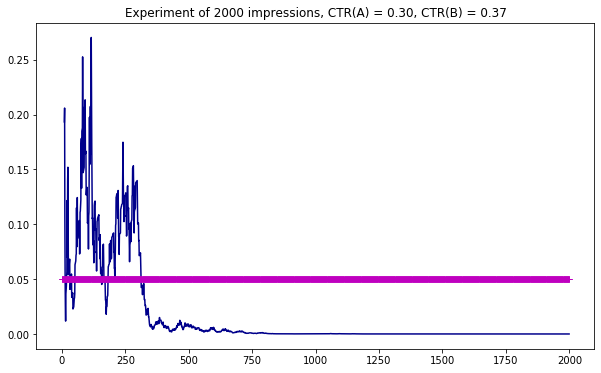

In [16]:
run_experiment(0.304,0.372, 2000)

**Case 2:** Our experiment becomes statistically significant after less than 250 iterations! 

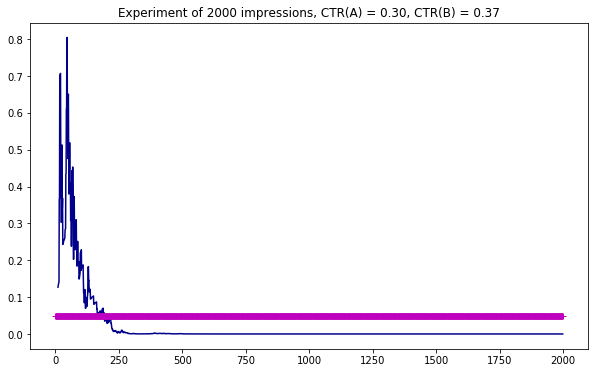

In [17]:
run_experiment(0.304,0.372, 2000)

**Case 3:** Our experiment is only significant after more than 1000 iterations.

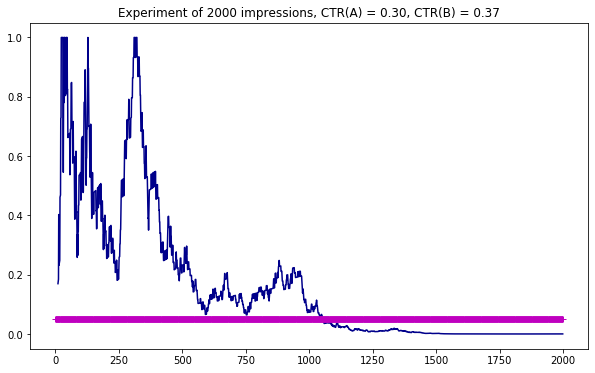

In [18]:
run_experiment(0.304,0.372, 2000)

**Case 4:**  The experiment becomes insignificant, significant, insignificant and then significant after aproximately 900 iterations.

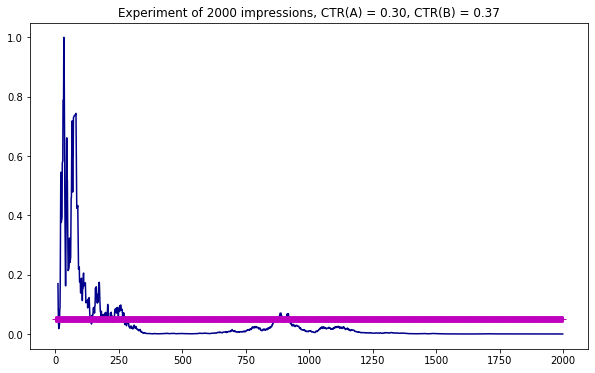

In [19]:
run_experiment(0.304,0.372, 2000)

Remember that the $p$-value should be below the threshold,  $\alpha$% of the time in order to have significance in an AB-testing.